# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History



### Results that did the best from Decision Tree Classifier with player diff + one hot encoded categorial features:


# Summary of Results




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


from datetime import datetime
import pickle
import json
import os
import sys
import re
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
import util.model_util as mu
from util.model_util import RSTATE, N_JOBS, MAX_ITER, LABEL_COL
from sklearn.model_selection import train_test_split


%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-stats"

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    mu.ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-raw_diff-ohe-history-matchup-stats.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"

else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv'

START_YEAR = 1985
END_YEAR = 2018



In [2]:
features = pd.read_csv(FEATURE_FILE)
features = features[features.tourney_year <= END_YEAR]
labels = features[LABEL_COL]

In [3]:
features1998 = features[features.tourney_year >= 1998]
labels1998 = features1998[LABEL_COL]

# Gradient Boosting - Baseline

If I didn't know anything about tennis, I would use seed diff to make my predictions.

From EDA, this should result in about 65% accuracy

In [4]:
def filter_baseline_features(data: pd.DataFrame):

    seed_filter = mu.BaseRankDiffFilter(data)
    new_data = seed_filter.get_data()
    
    return new_data

features_baseline = filter_baseline_features(features)

In [5]:
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(features_baseline, labels, random_state = RSTATE)

In [6]:

# train our model

gb_baseline = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-baseline', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_baseline,
                   y_train = y_train_baseline,
                   X_test = X_test_baseline,
                   y_test = y_test_baseline, 
                  data_filter = filter_baseline_features).fit()
y_predict_baseline = gb_baseline.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3648            1.01s
         2           1.3474            1.01s
         3           1.3331            1.01s
         4           1.3214            1.00s
         5           1.3118            0.98s
         6           1.3038            0.97s
         7           1.2973            0.96s
         8           1.2919            0.94s
         9           1.2875            0.98s
        10           1.2838            0.97s
        20           1.2689            0.84s
        30           1.2665            0.72s
        40           1.2660            0.62s


Model Score: 0.6531069827033953

ROC/AUC Score: 0.6531133501167702
              precision    recall  f1-score   support

        Loss       0.66      0.65      0.65     12522
         Win       0.65      0.66      0.65     12454

    accuracy                           0.65     24976
   macro avg       0.65      0.65      0.65     24976
weighted avg       0.65      0.65      0.65     24976

      Loss   Win
Loss  8149  4373
Win   4291  8163


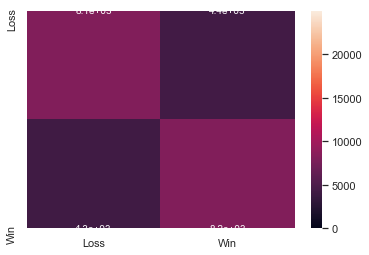

In [7]:
gb_baseline.analyze()

In [8]:
gb_baseline.save()

Saving report: ../reports/summary.csv


In [9]:
report = pd.DataFrame()
report = report.append({"accuracy": gb_baseline.accuracy, "description": gb_baseline.description}, ignore_index=True)

# Gradient Boosting - Raw Data(OHE) and Raw Stats

In [10]:
def filter_raw_plus_stats_features(data: pd.DataFrame):

    print(f'Before: shape {data.shape}')

    
    default = mu.DefaultColumnFilter(data)
    raw = mu.StatsRawFilter(data)
    
    new_data = pd.concat([default.get_data(), raw.get_data()], axis=1)
    
    print(f'After: shape {data.shape}')
    
    return new_data


In [11]:
features_raw = filter_raw_plus_stats_features(features)
# let's see what's left
[col for col in features_raw.columns if re.search("stats", col)]

Before: shape (99901, 5460)
After: shape (99901, 5460)


['p1_stats_1stin_avg',
 'p1_stats_1stwon_avg',
 'p1_stats_2ndwon_avg',
 'p1_stats_ace_avg',
 'p1_stats_bpfaced_avg',
 'p1_stats_bpsaved_avg',
 'p1_stats_df_avg',
 'p1_stats_svgms_avg',
 'p1_stats_svpt_avg',
 'p2_stats_1stin_avg',
 'p2_stats_1stwon_avg',
 'p2_stats_2ndwon_avg',
 'p2_stats_ace_avg',
 'p2_stats_bpfaced_avg',
 'p2_stats_bpsaved_avg',
 'p2_stats_df_avg',
 'p2_stats_svgms_avg',
 'p2_stats_svpt_avg']

In [12]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(features_raw, labels, random_state = RSTATE)

In [13]:

# train our model

gb = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_raw,
                   y_train = y_train_raw,
                   X_test = X_test_raw,
                   y_test = y_test_raw, 
                  data_filter = filter_raw_plus_stats_features).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3642           27.38m
         2           1.3461           26.97m
         3           1.3312           26.72m
         4           1.3183           26.59m
         5           1.3079           25.93m
         6           1.2990           25.96m
         7           1.2915           26.40m
         8           1.2853           26.29m
         9           1.2798           26.07m
        10           1.2750           25.88m
        20           1.2500           23.80m
        30           1.2390           21.12m
        40           1.2317           18.55m
        50           1.2270           15.64m
        60           1.2234           12.60m
        70           1.2203            9.50m
        80           1.2176            6.36m
        90           1.2151            3.15m
       100           1.2129            0.00s


Model Score: 0.6627562459961563

ROC/AUC Score: 0.6627623579064201
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8271  4251
Win   4172  8282


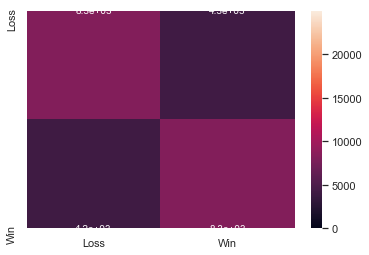

In [14]:
gb.analyze()

In [15]:
gb.save()

Saving report: ../reports/summary.csv


In [16]:
report = report.append({"accuracy": gb.accuracy, "description": gb.description}, ignore_index=True)

# Grandient Boosting - Raw Data(OHE) and Diff Stats

Diffed all time average player stats

In [17]:
import importlib
importlib.reload(mu)

def filter_stats_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)
    stats_diff = mu.StatsDiffFilter(data)
    new_data = pd.concat([default.get_data(), stats_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

stats_diff = filter_stats_diff_features(features)
# let's see what's left
[col for col in stats_diff.columns if re.search("stats", col)]

Before: shape (99901, 5460)
After: shape (99901, 5262)


['p1_stats_1stin_avg_diff',
 'p1_stats_1stwon_avg_diff',
 'p1_stats_2ndwon_avg_diff',
 'p1_stats_ace_avg_diff',
 'p1_stats_bpfaced_avg_diff',
 'p1_stats_bpsaved_avg_diff',
 'p1_stats_df_avg_diff',
 'p1_stats_svgms_avg_diff',
 'p1_stats_svpt_avg_diff']

In [18]:
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(stats_diff, labels, random_state = RSTATE)

In [19]:

# train our model

gb_diff = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_diff,
                   y_train = y_train_diff,
                   X_test = X_test_diff,
                   y_test = y_test_diff, 
                  data_filter = filter_stats_diff_features).fit()
y_predict_gb_dfiff = gb_diff.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3637           26.36m
         2           1.3452           25.20m
         3           1.3299           24.03m
         4           1.3172           22.99m
         5           1.3066           22.24m
         6           1.2977           21.70m
         7           1.2902           21.20m
         8           1.2839           20.77m
         9           1.2785           20.54m
        10           1.2739           20.18m
        20           1.2506           17.45m
        30           1.2409           15.28m
        40           1.2348           13.09m
        50           1.2307           10.89m
        60           1.2268            8.65m
        70           1.2240            6.43m
        80           1.2212            4.27m
        90           1.2190            2.13m
       100           1.2163            0.00s


Model Score: 0.6619554772581678

ROC/AUC Score: 0.66197095809304
              precision    recall  f1-score   support

        Loss       0.67      0.66      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8218  4304
Win   4139  8315


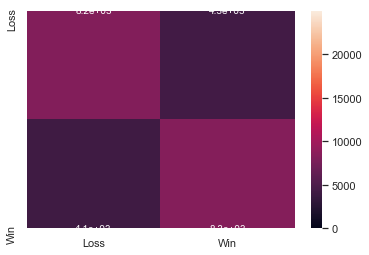

In [20]:
gb_diff.analyze()

In [21]:
gb_diff.save()

Saving report: ../reports/summary.csv


In [22]:
report = report.append({"accuracy": gb_diff.accuracy, "description": gb_diff.description}, ignore_index=True)

# Grandient Boosting - Raw Data(OHE) + stats5 diff

Average stats for each player diffed (ie, p1 - p2 stats)

In [23]:
import importlib
importlib.reload(mu)

def filter_stats5_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)

    stats_diff = mu.StatsDiffFilter(data)
    stats5_diff = mu.Stats5DiffFilter(data)

    new_data = pd.concat([default.get_data(), stats_diff.get_data(), stats5_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

stats5_diff = filter_stats_diff_features(features)
# let's see what's left
[col for col in stats_diff.columns if re.search("stats", col)]

Before: shape (99901, 5460)
After: shape (99901, 5262)


['p1_stats_1stin_avg_diff',
 'p1_stats_1stwon_avg_diff',
 'p1_stats_2ndwon_avg_diff',
 'p1_stats_ace_avg_diff',
 'p1_stats_bpfaced_avg_diff',
 'p1_stats_bpsaved_avg_diff',
 'p1_stats_df_avg_diff',
 'p1_stats_svgms_avg_diff',
 'p1_stats_svpt_avg_diff']

In [24]:
X_train_diff5, X_test_diff5, y_train_diff5, y_test_diff5 = train_test_split(stats5_diff, labels, random_state = RSTATE)

In [25]:
gb_diff5 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff5', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_diff5,
                   y_train = y_train_diff5,
                   X_test = X_test_diff5,
                   y_test = y_test_diff5, 
                  data_filter = filter_stats5_diff_features).fit()
y_predict_gb_dfiff5 = gb_diff5.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3637           20.51m
         2           1.3452           20.24m
         3           1.3299           20.04m
         4           1.3172           20.12m
         5           1.3066           20.06m
         6           1.2977           20.04m
         7           1.2902           20.04m
         8           1.2839           19.92m
         9           1.2785           19.80m
        10           1.2739           19.65m
        20           1.2506           17.38m
        30           1.2409           15.29m
        40           1.2348           13.11m
        50           1.2307           10.85m
        60           1.2268            8.60m
        70           1.2240            6.37m
        80           1.2212            4.23m
        90           1.2190            2.10m
       100           1.2163            0.00s


Model Score: 0.6619554772581678

ROC/AUC Score: 0.66197095809304
              precision    recall  f1-score   support

        Loss       0.67      0.66      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8218  4304
Win   4139  8315


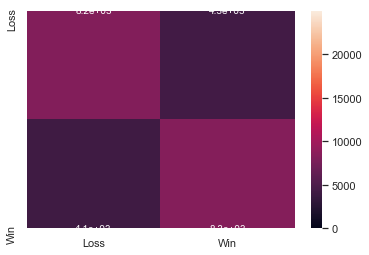

In [26]:
gb_diff5.analyze()

In [27]:
gb_diff5.save()

Saving report: ../reports/summary.csv


In [28]:
report = report.append({"accuracy": gb_diff5.accuracy, "description": gb_diff5.description}, ignore_index=True)

# Sample Weights

We saw from inital EDA, that upset rate is changing over the past couple of decades which means that earlier samples may not be as meaningful in our predictions as later samples. We will assign weights to our samples according to the year the tournament was in.

This first method assigns a different weight to each year with the last year in our samples 2018 having the highest weight.

We will compare results with the best so far:

```
Model Score: 0.6627562459961563

ROC/AUC Score: 0.6627623579064201
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976
```

In [29]:
importlib.reload(mu)
# assign sample weights
ywc = mu.IntervalBasedWeightCalculator(X_train_diff, "tourney_year", 1)
gb_diff_ywc = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff-weights_bin1', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_diff,
                   y_train = y_train_diff,
                   X_test = X_test_diff,
                   y_test = y_test_diff, 
                  data_filter = filter_stats_diff_features).fit(sample_weights = ywc.get_weights())
y_predict_gb_diff_ywc = gb_diff_ywc.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3622           20.47m
         2           1.3426           20.22m
         3           1.3262           20.96m
         4           1.3128           21.01m
         5           1.3015           20.94m
         6           1.2921           20.80m
         7           1.2840           20.60m
         8           1.2773           20.42m
         9           1.2715           20.24m
        10           1.2667           20.05m
        20           1.2418           17.84m
        30           1.2317           15.47m
        40           1.2250           13.08m
        50           1.2200           10.71m
        60           1.2157            8.49m
        70           1.2117            6.34m
        80           1.2082            4.21m


### This looks promising. Not drastic accuracy increase but there is some

Model Score: 0.6596732863549007

ROC/AUC Score: 0.6596958359229621
              precision    recall  f1-score   support

        Loss       0.66      0.65      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8157  4365
Win   4135  8319


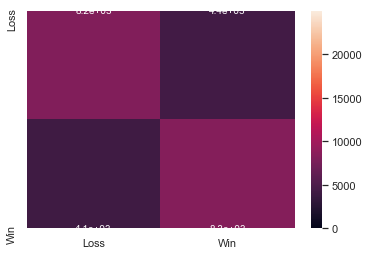

In [30]:
gb_diff_ywc.analyze()

In [31]:
gb_diff_ywc.save()

Saving report: ../reports/summary.csv


In [32]:
report = report.append({"accuracy": gb_diff_ywc.accuracy, "description": gb_diff_ywc.description}, ignore_index=True)

# Sample Weights - 10 bins

With this method, we will take years of tournament and construct equal sized bins. We wills start with 10 bins

We will compare results to the following:

```

```

In [33]:
# assign sample weights
ybwc10 = mu.BinBasedWeightCalculator(X_train_diff, "tourney_year", 10)
gb_diff_yb10 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff-weights_bin1', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_stats_diff_features)
gb_diff_yb10.fit(X_train_diff, y_train_diff, sample_weights = ybwc10.get_weights())
y_predict_gb_diff_yb10 = gb_diff_yb10.predict(X_test_diff)

      Iter       Train Loss   Remaining Time 
         1           1.3622           22.13m
         2           1.3426           21.68m
         3           1.3263           21.66m
         4           1.3129           21.47m
         5           1.3017           21.14m
         6           1.2922           20.82m
         7           1.2841           20.57m
         8           1.2773           20.24m
         9           1.2716           19.83m
        10           1.2668           19.50m
        20           1.2420           17.49m
        30           1.2317           15.33m
        40           1.2252           13.07m
        50           1.2198           10.78m
        60           1.2155            8.51m
        70           1.2120            6.33m
        80           1.2084            4.21m


Model Score: 0.6612748238308777

ROC/AUC Score: 0.6612943329904776
              precision    recall  f1-score   support

        Loss       0.66      0.65      0.66     12522
         Win       0.66      0.67      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8191  4331
Win   4129  8325


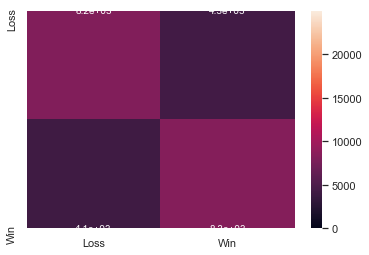

In [34]:
gb_diff_yb10.analyze(y_test_diff)

In [35]:
gb_diff_yb10.save()

Saving report: ../reports/summary.csv


In [36]:
report = report.append({"accuracy": gb_diff_yb10.accuracy, "description": gb_diff_yb10.description}, ignore_index=True)

# Sample Weights - Bin Every 5 Years

Since we saw in EDA that there might be a significant drop or increase in upset rates every 5 years. Our data covers 20 years, so let's try using 4 bins and see how this affects our model


We will compare results to the following:

```

```

In [37]:
# assign sample weights
ybwc4 = mu.IntervalBasedWeightCalculator(X_train_diff, "tourney_year", 5)
gb_diff_yb4 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff-weights_bin5yr', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_stats_diff_features).fit(X_train_diff, y_train_diff, sample_weights = ybwc4.get_weights())
y_predict_gb_diff_yb4 = gb_diff_yb4.predict(X_test_diff)

      Iter       Train Loss   Remaining Time 
         1           1.3623           21.71m
         2           1.3427           21.58m
         3           1.3265           21.30m
         4           1.3131           21.13m
         5           1.3018           20.98m
         6           1.2924           20.80m
         7           1.2843           20.53m
         8           1.2777           20.33m
         9           1.2719           20.15m
        10           1.2670           19.89m
        20           1.2422           17.35m
        30           1.2321           15.25m
        40           1.2260           13.01m
        50           1.2204           10.79m
        60           1.2161            8.53m
        70           1.2121            6.34m
        80           1.2087            4.21m
        90           1.2062            2.10m
       100           1.2033            0.00s


Model Score: 0.6604740550928891

ROC/AUC Score: 0.6604839654361848
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12522
         Win       0.66      0.66      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8225  4297
Win   4183  8271


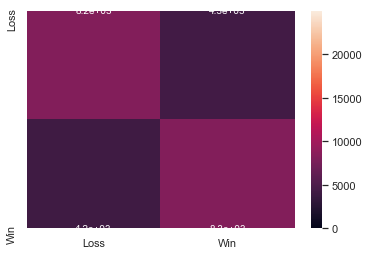

In [38]:
gb_diff_yb4.analyze(y_test_diff)

In [39]:
gb_diff_yb4.save()

Saving report: ../reports/summary.csv


In [40]:
report = report.append({"accuracy": gb_diff_yb4.accuracy, "description": gb_diff_yb4.description}, ignore_index=True)

#  History Diff Data Year Bin Every 5 Years

In [41]:
importlib.reload(mu)

def filter_history5_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)

    history_diff = mu.History5PercentageDiffFilter(data)

    new_data = pd.concat([default.get_data(), history_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

history5_diff = filter_history5_diff_features(features)
# let's see what's left
[col for col in history5_diff.columns if re.search(r"history", col)]

Before: shape (99901, 5460)
After: shape (99901, 5256)


['p1_history5_games_won_percentage_diff',
 'p1_history5_sets_won_percentage_diff',
 'p1_history5_win_percentage_diff']

In [42]:
X_train_history5_diff, X_test_history5_diff, y_train_history5_diff, y_test_history5_diff = \
                train_test_split(history5_diff, labels, random_state = RSTATE)

In [43]:
gb_history5_diff = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff-weight_bin5yr', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_history5_diff_features)
gb_history5_diff.fit(X_train_history5_diff, y_train_history5_diff, sample_weights = ybwc4.get_weights())
y_predict_gb_history5_diff = gb_history5_diff.predict(X_test_history5_diff)

      Iter       Train Loss   Remaining Time 
         1           1.3642           22.03m
         2           1.3464           21.59m
         3           1.3317           21.23m
         4           1.3196           20.87m
         5           1.3097           20.65m
         6           1.3012           20.27m
         7           1.2942           19.89m
         8           1.2883           19.59m
         9           1.2833           19.33m
        10           1.2790           19.05m
        20           1.2581           17.26m
        30           1.2492           15.10m
        40           1.2443           12.83m
        50           1.2401           10.54m
        60           1.2366            8.32m
        70           1.2338            6.20m
        80           1.2313            4.12m
        90           1.2290            2.05m
       100           1.2269            0.00s


Model Score: 0.6556694426649584

ROC/AUC Score: 0.6556653641125263
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12522
         Win       0.65      0.65      0.65     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8229  4293
Win   4307  8147


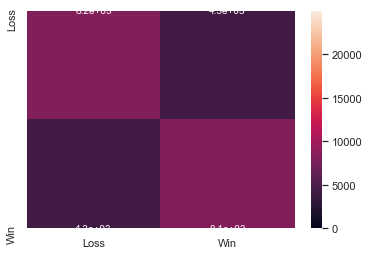

In [44]:
gb_history5_diff.analyze(y_test_history5_diff)

In [45]:
gb_history5_diff.save()

Saving report: ../reports/summary.csv


In [46]:
report = report.append({"accuracy": gb_history5_diff.accuracy, "description": gb_history5_diff.description}, ignore_index=True)

# Combine History Diff Data with Stats Diff and Bin Every 5 Years

In [47]:
importlib.reload(mu)

def filter_history_diff_stats5_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)

    stats_diff = mu.StatsDiffFilter(data)
    history_diff = mu.History5PercentageDiffFilter(data)

    new_data = pd.concat([default.get_data(), stats_diff.get_data(), history_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

history5_stats5_diff = filter_history_diff_stats5_diff_features(features)
# let's see what's left
[col for col in history5_stats5_diff.columns if re.search(r"(stats|history)", col)]

Before: shape (99901, 5460)
After: shape (99901, 5265)


['p1_stats_1stin_avg_diff',
 'p1_stats_1stwon_avg_diff',
 'p1_stats_2ndwon_avg_diff',
 'p1_stats_ace_avg_diff',
 'p1_stats_bpfaced_avg_diff',
 'p1_stats_bpsaved_avg_diff',
 'p1_stats_df_avg_diff',
 'p1_stats_svgms_avg_diff',
 'p1_stats_svpt_avg_diff',
 'p1_history5_games_won_percentage_diff',
 'p1_history5_sets_won_percentage_diff',
 'p1_history5_win_percentage_diff']

In [48]:
X_train_history5_stats5_diff, X_test_history5_stats5_diff, y_train_history5_stats5_diff, y_test_history5_stats5_diff = \
                train_test_split(history5_stats5_diff, labels, random_state = RSTATE)

In [49]:
gb_history5_stats5_diff = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff-stats5_diff-weights_bin5yr', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_history_diff_stats5_diff_features)
gb_history5_stats5_diff.fit(X_train_history5_stats5_diff, y_train_history5_stats5_diff, sample_weights = ybwc4.get_weights())
y_predict_gb_history_5_stats5 = gb_history5_stats5_diff.predict(X_test_history5_stats5_diff)

      Iter       Train Loss   Remaining Time 
         1           1.3623           20.30m
         2           1.3427           20.07m
         3           1.3265           20.20m
         4           1.3131           20.39m
         5           1.3018           20.25m
         6           1.2924           20.35m
         7           1.2843           20.21m
         8           1.2777           20.10m
         9           1.2719           19.92m
        10           1.2670           19.75m
        20           1.2422           17.71m
        30           1.2321           15.42m
        40           1.2260           13.09m
        50           1.2204           10.71m
        60           1.2161            8.47m
        70           1.2121            6.35m
        80           1.2087            4.21m
        90           1.2062            2.10m
       100           1.2033            0.00s


Model Score: 0.6605140935297886

ROC/AUC Score: 0.6605238951598711
              precision    recall  f1-score   support

        Loss       0.66      0.66      0.66     12522
         Win       0.66      0.66      0.66     12454

    accuracy                           0.66     24976
   macro avg       0.66      0.66      0.66     24976
weighted avg       0.66      0.66      0.66     24976

      Loss   Win
Loss  8226  4296
Win   4183  8271


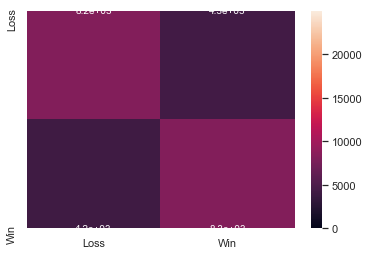

In [50]:
gb_history5_stats5_diff.analyze(y_test_history5_stats5_diff)

In [51]:
gb_history5_stats5_diff.save()

Saving report: ../reports/summary.csv


In [52]:
report = report.append({"accuracy": gb_history5_stats5_diff.accuracy, "description": gb_history5_stats5_diff.description}, ignore_index=True)

# Combine History Diff Data with Stats Diff and 5 Year Bins - 1998 Data

In [53]:
importlib.reload(mu)

# def filter_history_diff_stats5_diff_features(data: pd.DataFrame):
    
#     print(f'Before: shape {data.shape}')
    
#     default = mu.DefaultColumnFilter(data)

#     stats_diff = mu.StatsDiffFilter(data)
#     history_diff = mu.History5PercentageDiffFilter(data)

#     new_data = pd.concat([default.get_data(), stats_diff.get_data(), history_diff.get_data()], axis=1)
    
#     print(f'After: shape {new_data.shape}')
    
#     return new_data

history5_stats5_diff1998 = filter_history_diff_stats5_diff_features(features1998)
# let's see what's left
[col for col in history5_stats5_diff1998.columns if re.search(r"(stats|history)", col)]

Before: shape (59239, 5460)
After: shape (59239, 5265)


['p1_stats_1stin_avg_diff',
 'p1_stats_1stwon_avg_diff',
 'p1_stats_2ndwon_avg_diff',
 'p1_stats_ace_avg_diff',
 'p1_stats_bpfaced_avg_diff',
 'p1_stats_bpsaved_avg_diff',
 'p1_stats_df_avg_diff',
 'p1_stats_svgms_avg_diff',
 'p1_stats_svpt_avg_diff',
 'p1_history5_games_won_percentage_diff',
 'p1_history5_sets_won_percentage_diff',
 'p1_history5_win_percentage_diff']

In [54]:
X_train_history5_stats5_diff1998, X_test_history5_stats5_diff1998, y_train_history5_stats5_diff1998, y_test_history5_stats5_diff1998 = \
                train_test_split(history5_stats5_diff1998, labels1998, random_state = RSTATE)

In [55]:
ybwc4_1998 = mu.IntervalBasedWeightCalculator(X_train_history5_stats5_diff1998, "tourney_year", 5)

gb_history5_stats5_diff1998 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff-stats5_diff-weights_bin5yr', 
                 data_file = FEATURE_FILE,
                  start_year = 1998,
                  end_year = END_YEAR,
                  data_filter = filter_history_diff_stats5_diff_features)

gb_history5_stats5_diff1998.fit(X_train_history5_stats5_diff1998, y_train_history5_stats5_diff1998, sample_weights = ybwc4_1998.get_weights())

y_predict_gb_history_5_stats5_diff_1998 = gb_history5_stats5_diff1998.predict(X_test_history5_stats5_diff1998)

      Iter       Train Loss   Remaining Time 
         1           1.3602            9.43m
         2           1.3390            9.36m
         3           1.3214            9.26m
         4           1.3070            9.10m
         5           1.2948            9.01m
         6           1.2847            8.91m
         7           1.2761            8.81m
         8           1.2688            8.73m
         9           1.2626            8.63m
        10           1.2572            8.52m
        20           1.2291            7.56m
        30           1.2172            6.54m
        40           1.2098            5.54m
        50           1.2030            4.59m
        60           1.1981            3.63m
        70           1.1937            2.72m
        80           1.1899            1.81m
        90           1.1868           54.06s
       100           1.1838            0.00s


Model Score: 0.6656313301823092

ROC/AUC Score: 0.6656089971652157
              precision    recall  f1-score   support

        Loss       0.67      0.66      0.66      7381
         Win       0.66      0.67      0.67      7429

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4862  2519
Win   2433  4996


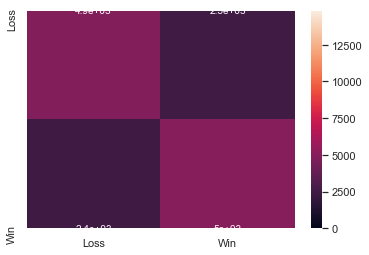

In [56]:
importlib.reload(mu)
gb_history5_stats5_diff1998.analyze(y_test_history5_stats5_diff1998)

In [57]:
gb_history5_stats5_diff1998.save()

Saving report: ../reports/summary.csv


In [58]:
report = report.append({"accuracy": gb_history5_stats5_diff1998.accuracy, "description": gb_history5_stats5_diff1998.description}, ignore_index=True)

# History Diff - 5 year bins (1998)

In [59]:
importlib.reload(mu)

def filter_history_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)

    history_diff = mu.History5PercentageDiffFilter(data)

    new_data = pd.concat([default.get_data(), history_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

history5_diff1998 = filter_history_diff_features(features1998)
# let's see what's left
[col for col in history5_diff1998.columns if re.search(r"(stats|history)", col)]

Before: shape (59239, 5460)
After: shape (59239, 5256)


['p1_history5_games_won_percentage_diff',
 'p1_history5_sets_won_percentage_diff',
 'p1_history5_win_percentage_diff']

In [60]:
X_train_history5_diff1998, X_test_history5_diff1998, y_train_history5_diff1998, y_test_history5_diff1998 = \
                train_test_split(history5_diff1998, labels1998, random_state = RSTATE)

In [61]:
ybwc4_1998 = mu.IntervalBasedWeightCalculator(X_train_history5_stats5_diff1998, "tourney_year", 5)

gb_history5_diff1998 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff-bin5', 
                 data_file = FEATURE_FILE,
                  start_year = 1998,
                  end_year = END_YEAR,
                  data_filter = filter_history_diff_features)

gb_history5_diff1998.fit(X_train_history5_diff1998, y_train_history5_diff1998, sample_weights = ybwc4_1998.get_weights())

y_predict_gb_history_5_stats5_diff_1998 = gb_history5_diff1998.predict(X_test_history5_diff1998)

      Iter       Train Loss   Remaining Time 
         1           1.3626            9.13m
         2           1.3433            9.15m
         3           1.3276            9.06m
         4           1.3146            8.88m
         5           1.3039            8.71m
         6           1.2948            8.57m
         7           1.2873            8.44m
         8           1.2809            8.34m
         9           1.2756            8.23m
        10           1.2709            8.12m
        20           1.2474            7.23m
        30           1.2365            6.32m
        40           1.2297            5.36m
        50           1.2250            4.44m
        60           1.2210            3.52m
        70           1.2178            2.63m
        80           1.2146            1.75m
        90           1.2120           52.23s


Model Score: 0.6600945307224848

ROC/AUC Score: 0.6601321029432237
              precision    recall  f1-score   support

        Loss       0.66      0.67      0.66      7381
         Win       0.67      0.65      0.66      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4958  2423
Win   2611  4818


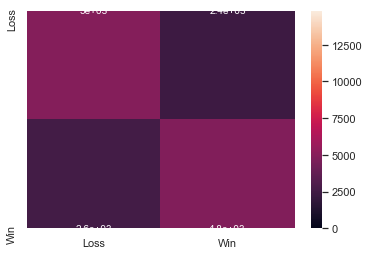

In [62]:
importlib.reload(mu)
gb_history5_diff1998.analyze(y_test_history5_diff1998)

In [63]:
gb_history5_diff1998.save()

Saving report: ../reports/summary.csv


In [64]:
report = report.append({"accuracy": gb_history5_diff1998.accuracy, "description": gb_history5_diff1998.description}, ignore_index=True)

# History Diff - no Bin (1998)

In [65]:
importlib.reload(mu)

# def filter_history_diff_features(data: pd.DataFrame):
    
#     print(f'Before: shape {data.shape}')
    
#     default = mu.DefaultColumnFilter(data)

#     history_diff = mu.History5PercentageDiffFilter(data)

#     new_data = pd.concat([default.get_data(), history_diff.get_data()], axis=1)
    
#     print(f'After: shape {new_data.shape}')
    
#     return new_data

# history5_diff1998_nobin = filter_history_diff_features(features1998)
# # let's see what's left
# [col for col in history5_diff1998.columns if re.search(r"(stats|history)", col)]

<module 'util.model_util' from '/Users/vinceluk/Dropbox/0_springboard/capstone2/util/model_util.py'>

In [66]:
# X_train_history5_diff1998, X_test_history5_diff1998, y_train_history5_diff1998, y_test_history5_diff1998 = \
#                 train_test_split(history5_diff1998, labels1998, random_state = RSTATE)

In [67]:

gb_history5_diff1998_nobin = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-history5_diff', 
                 data_file = FEATURE_FILE,
                  start_year = 1998,
                  end_year = END_YEAR,
                  data_filter = filter_history_diff_features)

gb_history5_diff1998_nobin.fit(X_train_history5_diff1998, y_train_history5_diff1998)

y_predict_gb_history_5_stats5_diff_1998 = gb_history5_diff1998_nobin.predict(X_test_history5_diff1998)

      Iter       Train Loss   Remaining Time 
         1           1.3644            9.38m
         2           1.3465            9.25m
         3           1.3319            9.06m
         4           1.3198            8.95m
         5           1.3099            8.84m
         6           1.3014            8.67m
         7           1.2944            8.52m
         8           1.2886            8.40m
         9           1.2835            8.29m
        10           1.2793            8.16m
        20           1.2578            7.11m
        30           1.2491            6.13m
        40           1.2432            5.19m
        50           1.2392            4.28m
        60           1.2356            3.41m
        70           1.2324            2.56m
        80           1.2298            1.70m
        90           1.2273           50.93s
       100           1.2251            0.00s


Model Score: 0.6602970965563808

ROC/AUC Score: 0.6603173821876497
              precision    recall  f1-score   support

        Loss       0.66      0.67      0.66      7381
         Win       0.66      0.65      0.66      7429

    accuracy                           0.66     14810
   macro avg       0.66      0.66      0.66     14810
weighted avg       0.66      0.66      0.66     14810

      Loss   Win
Loss  4920  2461
Win   2570  4859


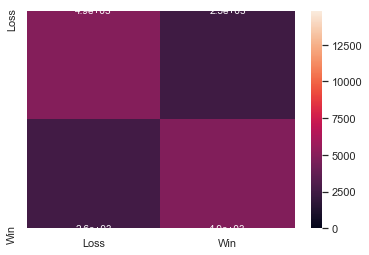

In [68]:
importlib.reload(mu)
gb_history5_diff1998_nobin.analyze(y_test_history5_diff1998)

In [69]:
gb_history5_diff1998_nobin.save()

Saving report: ../reports/summary.csv


In [70]:
report = report.append({"accuracy": gb_history5_diff1998_nobin.accuracy, "description": gb_history5_diff1998_nobin.description}, ignore_index=True)

# Results

In [71]:
report

,accuracy,description
0,0.653107,ohe-stats-baseline
1,0.662756,ohe-stats-stats
2,0.661955,ohe-stats-stats_diff
3,0.661955,ohe-stats-stats_diff5
4,0.659673,ohe-stats-stats_diff-weights_bin1
5,0.661275,ohe-stats-stats_diff-weights_bin1
6,0.660474,ohe-stats-stats_diff-weights_bin5yr
7,0.655669,ohe-stats-history5_diff-weight_bin5yr
8,0.660514,ohe-stats-history5_diff-stats5_diff-weights_bi...
9,0.665631,ohe-stats-history5_diff-stats5_diff-weights_bi...


Best Dataset: ohe-stats-history5_diff-stats5_diff-weights_bin5yr


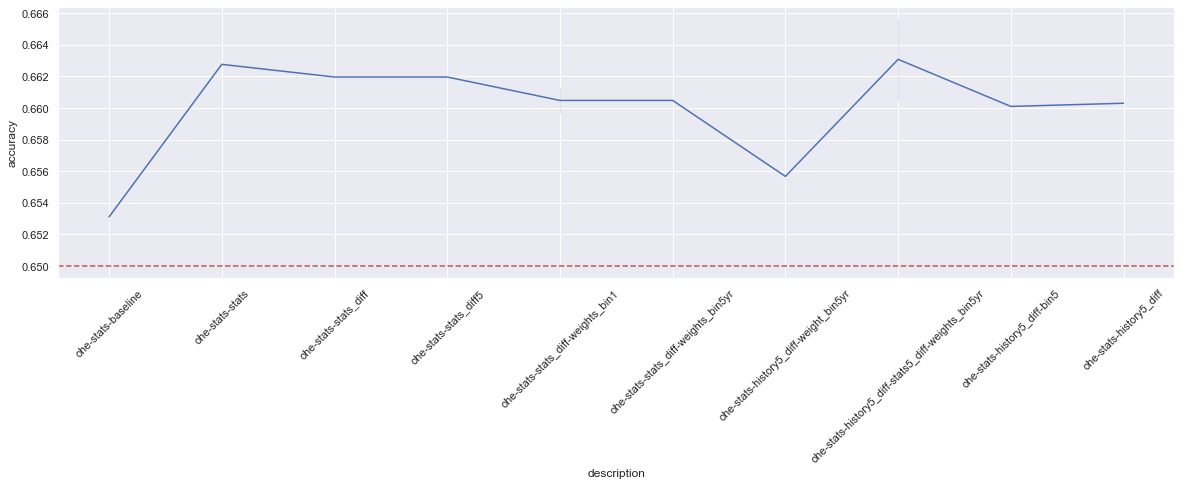

In [72]:
best_dataset = report.loc[report.accuracy.idxmax()].description
print(f'Best Dataset: {best_dataset}')

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"Accuracy")
_ = plt.xticks(rotation=45)


In [73]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(gb_history5_stats5_diff.model, data=X_train_history5_stats5_diff1998.values)
shap_values = explainer.shap_values(X_test_history5_stats5_diff1998.values)

AssertionError: The background dataset you provided does not cover all the leaves in the model, so TreeExplainer cannot run with the feature_dependence="tree_path_dependent" option! Try providing a larger background dataset, or using feature_dependence="independent".

In [74]:
shap.summary_plot(shap_values, X_test_history5_stats5_diff1998, max_display=30)

NameError: name 'shap_values' is not defined

In [75]:
shap.summary_plot(shap_values, feature_names=X_test_history5_stats5_diff1998.columns, title="Feature Importance")

NameError: name 'shap_values' is not defined

In [76]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-26 17:30
